In [34]:
%load_ext autoreload
%autoreload 2

from pystorm.hal import HAL, data_utils
from pystorm.PyDriver import bddriver as bd
from pystorm.hal.net_builder import NetBuilder
from pystorm.hal.run_control import RunControl
from pystorm.hal.calibrator import Calibrator, PoolSpec

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
np.random.seed(1)

# making a Y-by-X pool of D dims located at (LY, LX)

Y, X = (32, 32)
LY, LX = (0, 0)

N = X * Y
D = 1 # has to be 1 for this

SY = Y // 2
SX = X // 2

In [36]:
hal = HAL()
net_builder = NetBuilder(hal)
cal = Calibrator(hal)

opt_ps_in = PoolSpec(YX=(Y,X), loc_yx=(LY, LX), D=1)
DAC_vals = {
        'DAC_SOMA_REF': 1024,
        'DAC_DIFF_G': 1024,
        'DAC_DIFF_R': 1024}

opt_ps_out, opt_dacs, opt_encs, opt_offsets, std_encs, std_offsets, dbg = \
    cal.optimize_yield(opt_ps_in, dacs=DAC_vals, 
                       bias_twiddle_policy='greedy_flat', offset_source='calibration_db', validate=True,
                       get_encs_kwargs=dict(bin_time=2, discard_time=.4, num_sample_angles=3))

print(opt_dacs['DAC_DIFF_G'])
print(opt_dacs['DAC_DIFF_R'])

running sample sweep at sample_angle = 2.0943951023931953 rad
  taking 9 sample points for 2 unique encs
  will run for 0.3 min.
running 20 bootstraps


/Users/aneckar/pystorm2/pystorm/hal/calibrator.py:1205: RuntimeWarning: Mean of empty slice
  mean_encs = np.nanmean(bs_encs, axis=0)
/Users/aneckar/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/aneckar/pystorm2/pystorm/hal/calibrator.py:1207: RuntimeWarning: Mean of empty slice
  mean_offsets = np.nanmean(bs_offsets, axis=0)


123 neurons still need more points
running sample sweep at sample_angle = 1.0471975511965976 rad
  taking 9 sample points for 2 unique encs
  will run for 0.3 min.
running 20 bootstraps
101 neurons still need more points
running sample sweep at sample_angle = 0.5235987755982988 rad
  taking 9 sample points for 2 unique encs
  will run for 0.3 min.
running 20 bootstraps
97 neurons still need more points


/Users/aneckar/pystorm2/pystorm/hal/calibrator.py:380: RuntimeWarning: invalid value encountered in less
  good_options_mask = (intercept_options < 1) & (intercept_options > -1)
/Users/aneckar/pystorm2/pystorm/hal/calibrator.py:380: RuntimeWarning: invalid value encountered in greater
  good_options_mask = (intercept_options < 1) & (intercept_options > -1)


running sample sweep at sample_angle = 2.0943951023931953 rad
  taking 9 sample points for 2 unique encs
  will run for 0.3 min.
running 20 bootstraps
484 neurons still need more points
running sample sweep at sample_angle = 1.0471975511965976 rad
  taking 9 sample points for 2 unique encs
  will run for 0.3 min.
running 20 bootstraps
321 neurons still need more points
running sample sweep at sample_angle = 0.5235987755982988 rad
  taking 9 sample points for 2 unique encs
  will run for 0.3 min.
running 20 bootstraps
317 neurons still need more points
1024
1024


good exp: 718
good ver: 590


/Users/aneckar/pystorm2/pystorm/hal/calibrator.py:794: RuntimeWarning: invalid value encountered in less
  good_mask = (intercepts < 1) & (intercepts > -1)
/Users/aneckar/pystorm2/pystorm/hal/calibrator.py:794: RuntimeWarning: invalid value encountered in greater
  good_mask = (intercepts < 1) & (intercepts > -1)


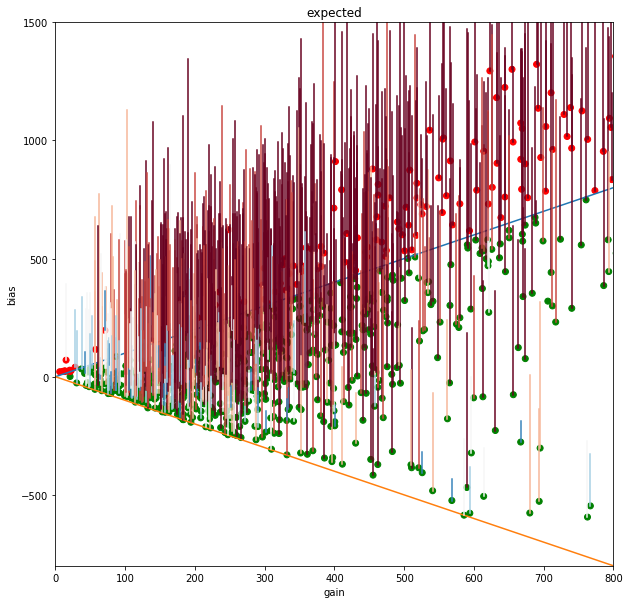

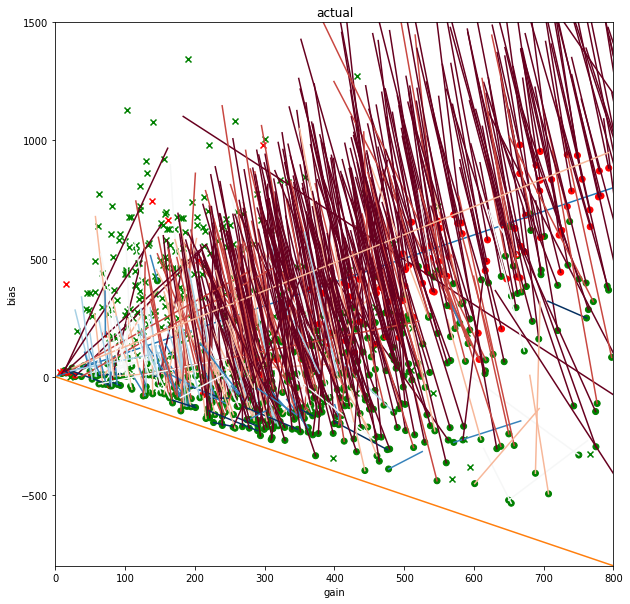

In [37]:
before_encs, before_offsets = dbg['before']
exp_encs, exp_offsets = dbg['expected']

opt_good = Calibrator.get_good_mask(opt_encs, opt_offsets)
exp_good = Calibrator.get_good_mask(exp_encs, exp_offsets)

print('good exp:', np.sum(exp_good))
print('good ver:', np.sum(opt_good))


fs = (10, 10)
xylim = (0, 800, -800, 1500)

Calibrator.plot_neuron_yield_cone(exp_encs, exp_offsets, exp_good,
                                 (before_encs, before_offsets, opt_ps_out.biases),
                                  title='expected',
                                  figsize=fs,
                                  xylim=xylim)

Calibrator.plot_neuron_yield_cone(opt_encs, opt_offsets, exp_good,
                                 (before_encs, before_offsets, opt_ps_out.biases),
                                  title='actual',
                                  figsize=fs,
                                  xylim=xylim)



In [58]:
N_val_samples = 200
val_pts = np.linspace(-1, 1, N_val_samples).reshape((N_val_samples, 1))
    
val_rmse, val_meas_A, val_est_A = cal.validate_est_encs(opt_encs, opt_offsets, opt_ps_out, val_pts)

done sweeping


/Users/aneckar/pystorm2/pystorm/hal/calibrator.py:777: RuntimeWarning: invalid value encountered in maximum
  est_A = np.maximum(0, np.dot(sample_pts, est_encs.T) + est_offsets)


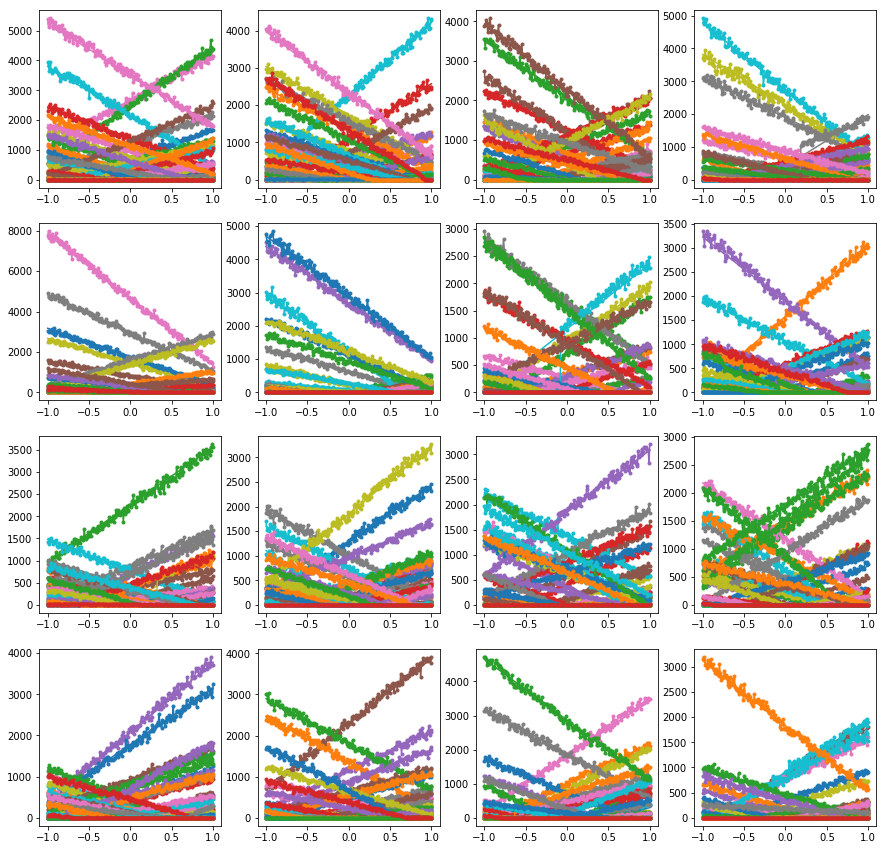

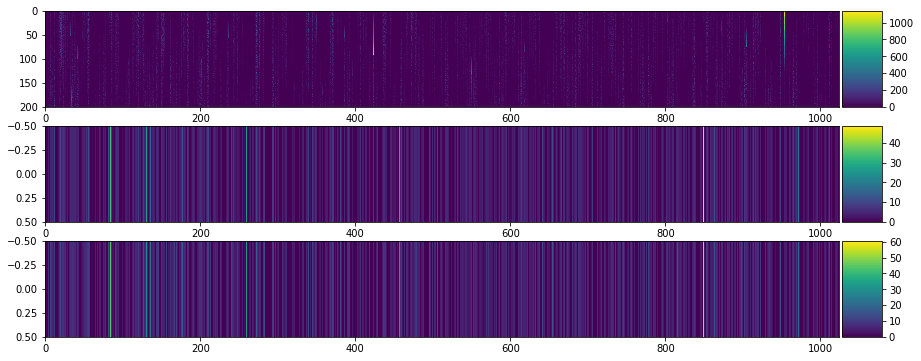

In [59]:
# try training on estimated tuning curves
sqrt_num_sets = 4
fig, ax = plt.subplots(sqrt_num_sets, sqrt_num_sets, figsize=(15, 15))
for y in range(sqrt_num_sets):
    for x in range(sqrt_num_sets):
        imin = (y * sqrt_num_sets + x) * N // sqrt_num_sets**2
        imax = imin + N // sqrt_num_sets**2
        
        ax[y, x].set_prop_cycle(None)
        ax[y, x].plot(val_pts, val_est_A[:, imin:imax])
        ax[y, x].set_prop_cycle(None)
        ax[y, x].plot(val_pts, val_meas_A[:, imin:imax], '.-')
        
        #ax[y, x].axis((-1, 1, 0, 1000))
        
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(3, 1, figsize=(15, 6))
diff = np.abs(val_est_A - val_meas_A)
diff[np.isnan(diff)] = 0
im = ax[0].imshow(diff, aspect='auto')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)

std_off = std_offsets.reshape((1, len(std_offsets)))
std_off[:, np.isnan(opt_offsets)] = 0
im = ax[1].imshow(std_off, aspect='auto') 
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)

std_enc = std_encs.reshape((1, len(std_encs)))
std_enc[:, np.isnan(opt_offsets)] = 0
im = ax[2].imshow(std_enc, aspect='auto') 
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)

18.532517562343127
32


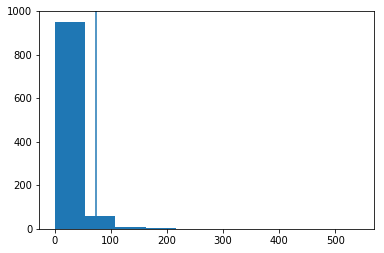

In [40]:
# toss out big error tuning curves

diff = np.abs(val_est_A - val_meas_A)
diff[np.isnan(diff)] = 0

plt.figure()
valid_means = np.sqrt(np.mean(diff**2, axis=0))
plt.hist(valid_means)

mean_rmse = np.mean(valid_means)
print(mean_rmse)

thr = 4
big_err = valid_means > thr * mean_rmse
plt.axvline(thr * mean_rmse)

print(np.sum(big_err))


In [41]:
from cvxpy import Variable, Problem, sum_squares, norm, Minimize

def run_cvx_opt(A, y, lam, kappa):
    
    SCALE = 1000
    Asc = A / SCALE
    ysc = y / SCALE
    
    d = Variable((N, 1))
    print((Asc * d).shape)
    print(ysc.shape)
    
    loss = sum_squares(Asc * d - ysc)

    cvx_prob = Problem(Minimize(loss + sum_squares(d) * lam + norm(d, 1) * kappa), [-1 <= d, d <= 1])
    
    #cvx_prob = Problem(Minimize(loss))
    #cvx_prob = Problem(Minimize(loss + sum_squares(d) * lam))
    #cvx_prob = Problem(Minimize(loss + sum_squares(d) * lam), [-1 <= d, d <= 1])
    #cvx_prob = Problem(Minimize(loss + sum_squares(d) * lam + norm(d, 1) * kappa))
    #cvx_prob = Problem(Minimize(loss + sum_squares(d) * lam + norm(d, 1) * kappa), [0 <= d, d <= 1])

    cvx_prob.solve()

    if cvx_prob.status == "failed":
        print("solver status:", cvx_prob.status)
        d = None
    else:
        if cvx_prob.status != "optimal":
            print("solver status:", cvx_prob.status)
            
        dstar = d.value

        print(dstar.shape)
        d = dstar.reshape(N, 1)
    return d


/Users/aneckar/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in maximum
  if sys.path[0] == '':


200
(200, 1)
(200, 1024)
(140, 1)
(140, 1)
(1024, 1)
0.2626953125
0.10033444816053512


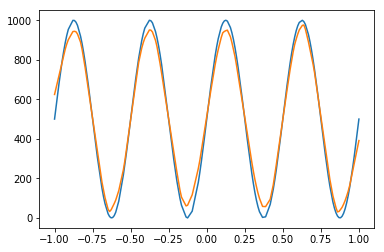

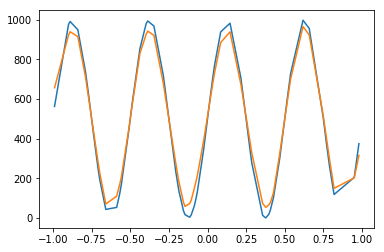

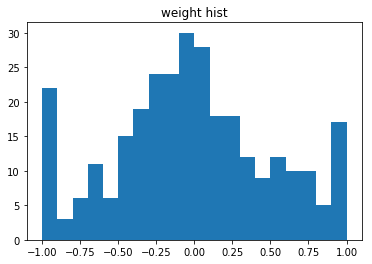

In [71]:
lam = .01
kappa = .01
train_frac = .7
fout = 1000

def yfn(x_pts):
    return fout * (np.sin(4*np.pi * x_pts) + 1)/2


N_sample = 200
x_pts = np.linspace(-1, 1, N_sample).reshape((N_sample, 1))
A_est = np.maximum(0, np.dot(x_pts, opt_encs.T) + opt_offsets)

#N_sample = N_val_samples
#x_pts = val_pts
#A_est = val_meas_A

print(N_sample)
print(x_pts.shape)
print(A_est.shape)

y = yfn(x_pts)

perm = np.random.permutation(np.arange(N_sample))
train_idxs = np.sort(perm[:int(N_sample * train_frac)])
test_idxs = np.sort(perm[int(N_sample * train_frac):])

A_est_val = A_est.copy()
A_est_val[np.isnan(A_est)] = 0
A_est_val[:, big_err] = 0 # throw out big errors

A_train = A_est_val[train_idxs, :]
A_test = A_est_val[test_idxs, :]
y_train = y[train_idxs, :]
y_test = y[test_idxs, :]
x_train = x_pts[train_idxs, :]
x_test = x_pts[test_idxs, :]

d = run_cvx_opt(A_train, y_train, lam, kappa)

yhat_train = np.dot(A_train, d)
yhat_test = np.dot(A_test, d)

plt.figure()
plt.plot(x_train, y_train)
plt.plot(x_train, yhat_train)

plt.figure()
plt.plot(x_test, y_test)
plt.plot(x_test, yhat_test)

plt.figure()
plt.hist(d[np.abs(d) > 1/128], bins=20)
plt.title('weight hist')

one = np.abs(d) > (1 - 1/128)
nonzero = np.abs(d) > 1 / 128
nonone = np.abs(d) < (1 - 1/128)

print((np.sum(nonzero & nonone)) / N)
print(np.sum(one) / (np.sum(nonzero & nonone) + np.sum(one)))

In [72]:
# now do real validation, run sweep
N_val_pts = 41
sample_pts = np.linspace(-1, 1, N_val_pts)
y_sample = yfn(sample_pts)

#######################

import time

HOLD_TIME = 1 # seconds
LPF_DISCARD_TIME = HOLD_TIME / 2 # seconds

# set up run controller to help us do sweeps
nb = NetBuilder(hal)
d_fixed = d.copy()
d_fixed[d > 1] = 1
d_fixed[d < -1] = -1
net = nb.create_single_pool_net_from_spec(opt_ps_out, decoders=d_fixed.T)
pool = net.get_pools()[0]
inp = net.get_inputs()[0]
out = net.get_outputs()[0]

hal.map(net)

for dac, value in opt_dacs.items():
    hal.set_DAC_value(dac, value)
# let the DACs settle down
time.sleep(.5)

run = RunControl(hal, net) 

tnow = hal.get_time()
times = np.arange(sample_pts.shape[0]) * HOLD_TIME * 1e9 + tnow + .1e9 
times_w_end = np.arange(sample_pts.shape[0] + 1) * HOLD_TIME * 1e9 + tnow + .1e9 
start_time = times[0]
end_time = times[-1] + HOLD_TIME * 1e9
sample_freqs = sample_pts * opt_ps_out.fmax

input_vals = {inp: (times, sample_freqs.reshape((len(sample_freqs), 1)))}

spikes_and_bin_times, _ = run.run_input_sweep(input_vals, get_raw_spikes=False, get_outputs=True, 
                                start_time=start_time, end_time=end_time, rel_time=False)
print("done sweeping")
spikes, spike_bin_times = spikes_and_bin_times

discard_frac = LPF_DISCARD_TIME / HOLD_TIME
meas_A = data_utils.bins_to_rates(spikes[out], spike_bin_times, times_w_end, init_discard_frac=discard_frac)


done sweeping


Text(0.5,1,'rmse = 208.76844445765437')

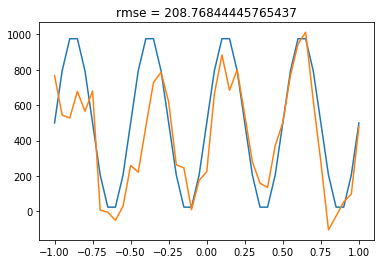

In [73]:
plt.figure()
plt.plot(sample_pts, y_sample)
plt.plot(sample_pts, meas_A)
rmse = np.sqrt(np.mean(((meas_A.flatten() - y_sample.flatten())**2)))
plt.title('rmse = ' + str(rmse))